# Setup-import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import xgboost as xgb

## Define Utilities

In [3]:
def plot_model_performance(y_pred, y_test):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    columns = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    data = [accuracy, precision, recall, f1]
    df_metrics = pd.DataFrame(data=data, index=columns, columns=['metrics'])

    # Plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar plot for metrics
    axes[0].bar(df_metrics.index, df_metrics['metrics'], color='grey')
    axes[0].set_xlabel('Metrics', fontsize=14)
    axes[0].set_ylabel('Scores', fontsize=14)
    axes[0].set_title('Model Performance Metrics', fontsize=20, fontweight='bold')
    axes[0].set_ylim(0, 1)
    for bar in axes[0].patches:
        height = bar.get_height()
        axes[0].annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    # Confusion matrix
    dt_cf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(dt_cf).plot(ax=axes[1], cmap='coolwarm')
    axes[1].set_title('Confusion Matrix', fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.show()

## Data loading 


In [4]:
apple_stock = yf.download('AAPL') 
apple_stock.drop(columns=['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
apple_stock.index = pd.to_datetime(apple_stock.index)
apple_stock = apple_stock[apple_stock.index > '2010-01-01']
apple_stock.index = pd.to_datetime(apple_stock.index)

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Calculate daily returns
apple_stock['Return'] = apple_stock['Adj Close'].pct_change()

# Drop missing values
apple_stock.dropna(inplace=True)

# Features: Using previous day's return and other technical indicators as features
apple_stock['Lag1'] = apple_stock['Return'].shift(1)
apple_stock['Lag2'] = apple_stock['Return'].shift(2)
apple_stock['SMA10'] = apple_stock['Adj Close'].rolling(window=10).mean()
apple_stock['SMA50'] = apple_stock['Adj Close'].rolling(window=50).mean()
apple_stock['SMA10'] = apple_stock['SMA10'].shift(1)
apple_stock['SMA50'] = apple_stock['SMA50'].shift(1)
apple_stock.dropna(inplace=True)

C:\Users\12436\AppData\Local\Temp\ipykernel_6136\1553970756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock['Return'] = apple_stock['Adj Close'].pct_change()
C:\Users\12436\AppData\Local\Temp\ipykernel_6136\1553970756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock.dropna(inplace=True)
C:\Users\12436\AppData\Local\Temp\ipykernel_6136\1553970756.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

## Train-test split

In [6]:
train = apple_stock[apple_stock.index <= '2023-01-01']
test = apple_stock[(apple_stock.index > '2023-01-01') & (apple_stock.index < '2024-01-01')]
test1 = apple_stock[apple_stock.index >= '2024-01-01']

train_test = apple_stock[apple_stock.index <= '2024-01-01']

print(f'Train set size: {train.shape}')
print(f'Validate set size: {test.shape}')
print(f'Test set size: {test1.shape}')

Train set size: (3221, 7)
Validate set size: (250, 7)
Test set size: (127, 7)


In [7]:
features = ['Lag1', 'Lag2', 'SMA10', 'SMA50']
target = 'Return'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_test1 = test1[features]
y_test1 = test1[target]

X_train_test = train_test[features]
y_train_test = train_test[target]

In [ ]:
# !pip install xgboost

### Hyperparameter tuning 

In [33]:
precision_lst =[]
combination_lst = []

n_estimators = [10, 50, 100, 200, 300, 400]
learning_rate = [0.005, 0.01, 0.05, 0.1]
max_depth = [3, 5, 7, 9, 11]


for a in n_estimators:
    for b in learning_rate:
        for c in max_depth:
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=b, max_depth=c, n_estimators=a)
            xgb_model.fit(X_train, y_train)

            y_pred = xgb_model.predict(X_test)
            df_xgboost = pd.DataFrame({
                                        'Actual data': y_test,
                                        'predicted data': y_pred
                                    }, index=y_test.index)
            df_xgboost['actual binary'] = np.where(df_xgboost['Actual data']>0,1,0)
            df_xgboost['predicted binary'] = np.where(df_xgboost['predicted data']>0,1,0)
            precision = precision_score(df_xgboost['actual binary'], df_xgboost['predicted binary'])
            precision_lst.append(precision)
            combination_lst.append([a,b,c])



,0,combination
90,0.645161,"[300, 0.05, 3]"


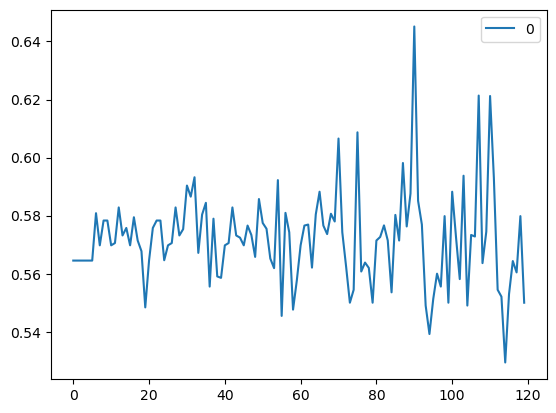

In [35]:
df = pd.DataFrame(data=precision_lst)
df.plot()
df['combination'] = combination_lst
df[df[0] == df[0].max()]

In [30]:
# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.05, max_depth=3, n_estimators=300)

# Train the model
xgb_model.fit(X_train_test, y_train_test)

y_pred = xgb_model.predict(X_test1)

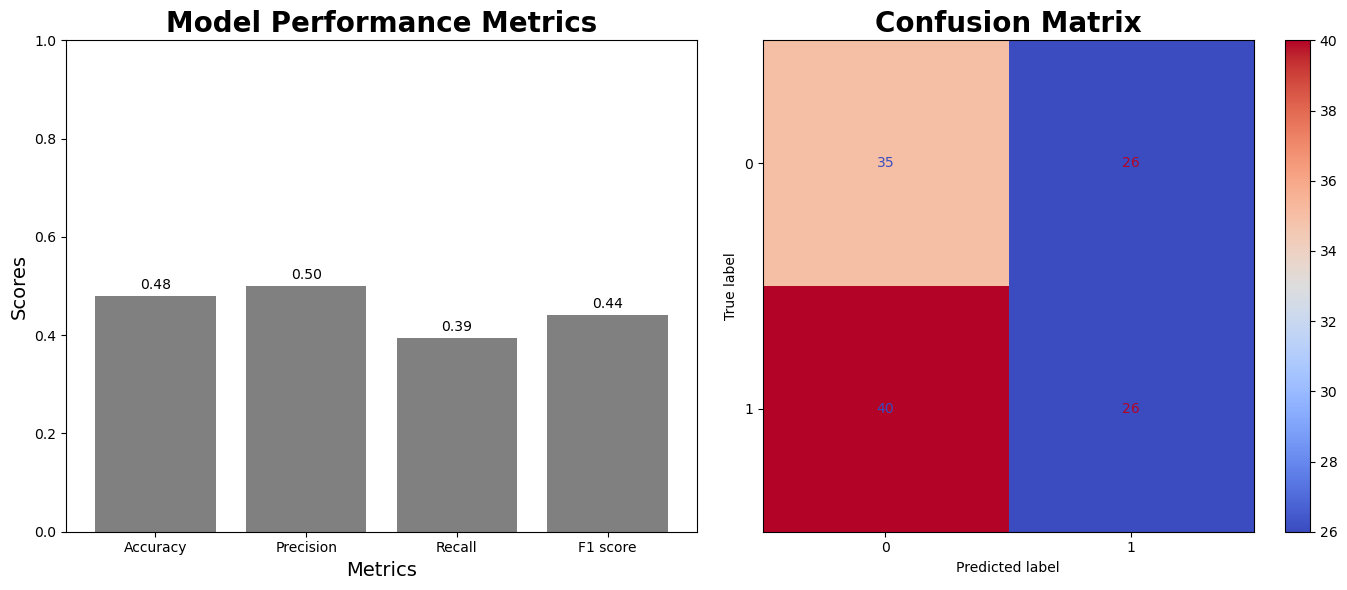

0.5

In [31]:
df_xgboost = pd.DataFrame({
    'Actual data': y_test1,
    'predicted data': y_pred
}, index=y_test1.index)
df_xgboost['actual binary'] = np.where(df_xgboost['Actual data']>0,1,0)
df_xgboost['predicted binary'] = np.where(df_xgboost['predicted data']>0,1,0)

plot_model_performance(df_xgboost['predicted binary'], df_xgboost['actual binary'])
precision = precision_score(df_xgboost['actual binary'], df_xgboost['predicted binary'])
precision